# TestCase4 - Plots correction

In [1]:
# sélection du cas test
testcase = 5
version = 2
param_num = 1

In [2]:
assert testcase == 5 and version in [1,2]

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from testcases.utils import create_tree

from testcases.geometry.geometry_2D import Donut
from modfenics.fenics_expressions.fenics_expressions import FExpr,UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
if version == 1:
    from testcases.networks.test_2D.test_5.test_5_v1 import Run_laplacian2D,Poisson_2D
elif version == 2:
    from testcases.networks.test_2D.test_5.test_5_v2 import Run_laplacian2D,Poisson_2D
from modfenics.solver_fem.solver_fem_5 import FEMSolver
from testcases.problem.problem_2D import TestCase5
problem = TestCase5(v=version)

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cpu


bigcenter :  [0.0, 0.0]
bigradius :  1.0
smallcenter :  [0.0, 0.0]
smallradius :  0.25
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/u2/lecourtier/Article1/networks/test_fe5_v2.pth
network loaded
Error  tensor([0.0003])


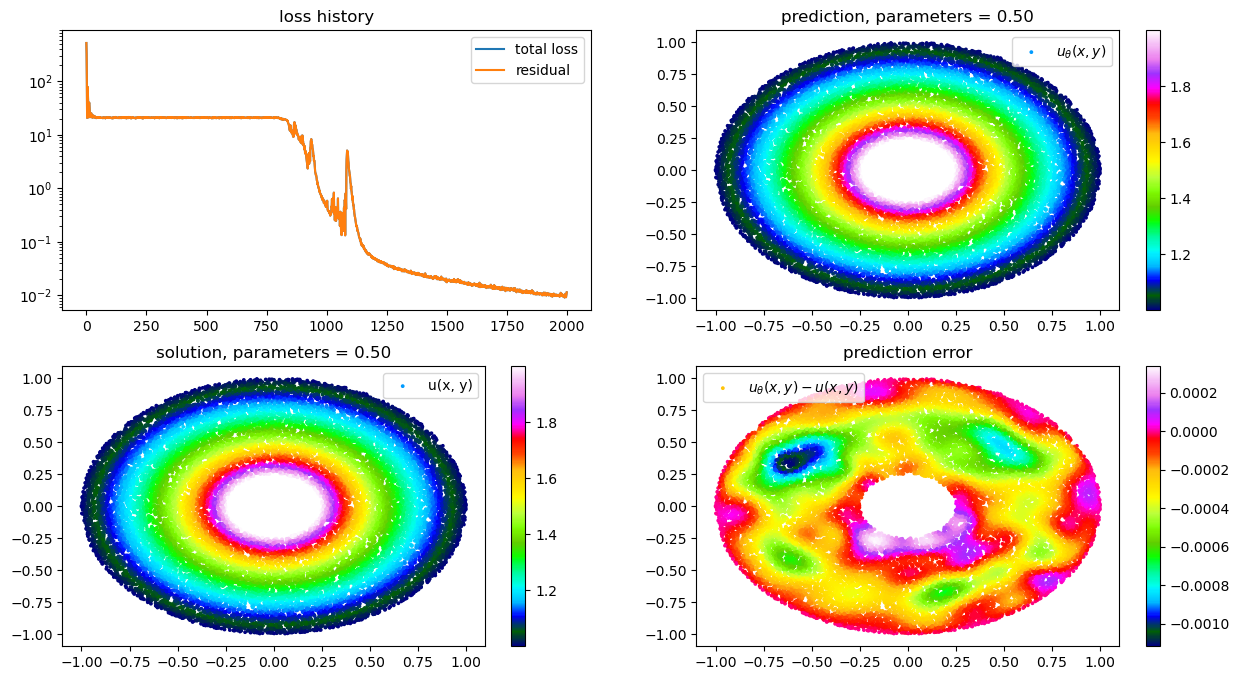

In [7]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [8]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


## Convergence FEM

In [9]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

hmax =  0.010988658015609403
Calling FFC just-in-time (JIT) compiler, this may take some time.
nb_vert=256, norme_L2=2.6311465590470283e-10
nb_vert=256, norme_L2=2.4262036224909892e-09


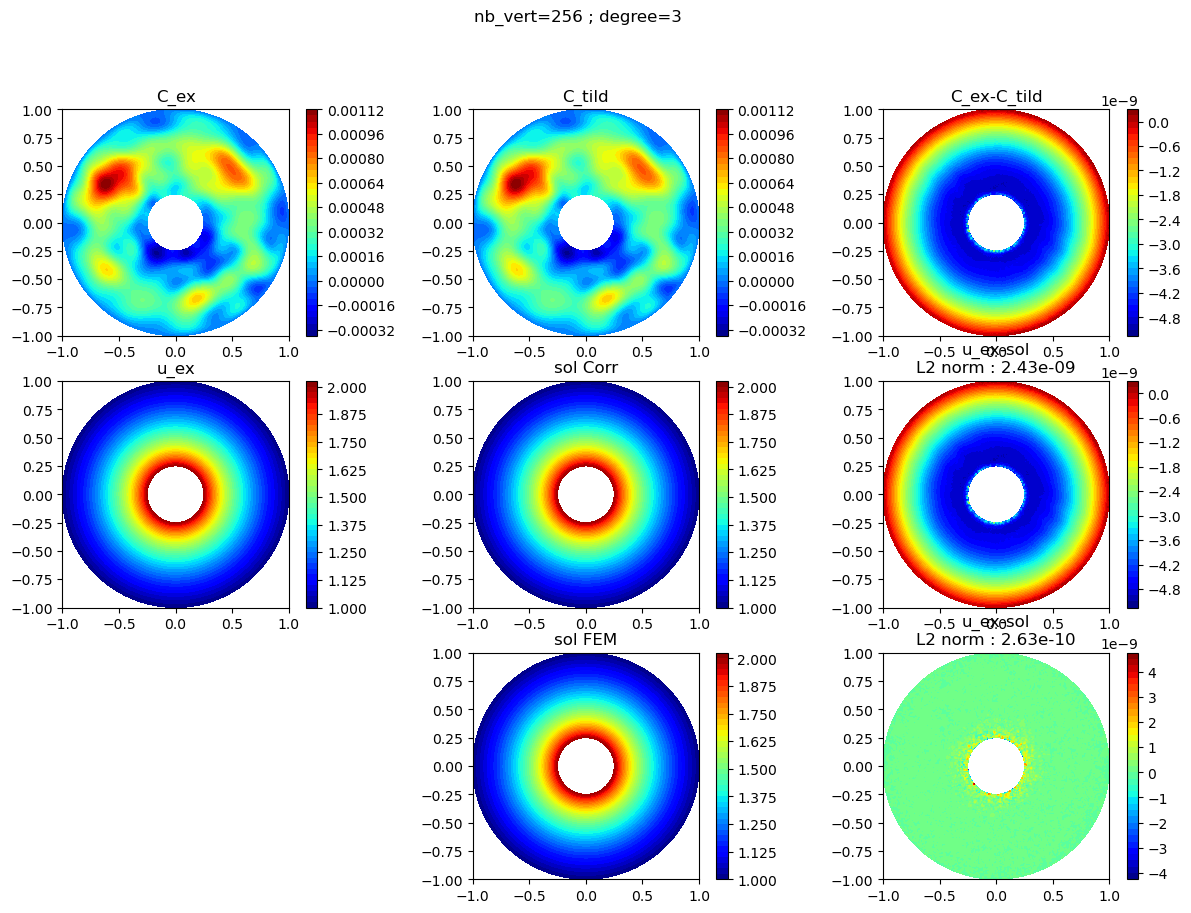

In [10]:
tab_nb_vert_FEM = [256]
tab_deg = [3]
degree_PINNs = 10

for degree in tab_deg:
    for nb_vert in tab_nb_vert_FEM:
        solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
        u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
        
        # FEM
        sol_FEM,norme_L2_FEM = solver.fem(0)
        print(f"nb_vert={nb_vert}, norme_L2={norme_L2_FEM}")
        
        # Compute PINNs solution
        V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
        u_PINNs = FEniCSpred(0,V_test,trainer)
        u_PINNs_inter = FEniCSpred(0,solver.V,trainer)
        sol,C_tild,norme_L2_Corr = solver.corr_add(0,u_PINNs,u_PINNs_inter)

        print(f"nb_vert={nb_vert}, norme_L2={norme_L2_Corr}")
        
        ### PLOTT
        colormap = "jet"

        C_ex = df.Function(solver.V)
        u_ref_inter = df.interpolate(u_ref,solver.V)
        C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_inter.vector()[:]

        plt.figure(figsize=(15,10))

        plt.subplot(3,3,1)
        c = df.plot(C_ex,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_ex")

        plt.subplot(3,3,2)
        c = df.plot(C_tild,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_tild")

        plt.subplot(3,3,3)
        error = df.Function(solver.V)
        error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_ex-C_tild")

        plt.subplot(3,3,4)
        c = df.plot(u_ref_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("u_ex")

        plt.subplot(3,3,5)
        # sol_inter = df.project(sol,solver.V)
        sol_inter = df.Function(solver.V)
        sol_inter.vector()[:] = u_PINNs_inter.vector()[:] + C_tild.vector()[:]
        c = df.plot(sol_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("sol Corr")

        plt.subplot(3,3,6)
        error = df.Function(solver.V)
        error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title(f"u_ex-sol\nL2 norm : {norme_L2_Corr:.2e}")
        
        # FEM
        plt.subplot(3,3,8)
        sol_inter = df.interpolate(sol_FEM,solver.V)
        c = df.plot(sol_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("sol FEM")

        plt.subplot(3,3,9)
        error = df.Function(solver.V)
        error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title(f"u_ex-sol\nL2 norm : {norme_L2_FEM:.2e}")    

        plt.suptitle(f"nb_vert={nb_vert} ; degree={degree}")

        plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}_new.png')